# Session 2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
%matplotlib inline

### Advertising Sales Data

In this session, we will use the advertising sales data that is provided by one of the authors of the book [Introduction to Statsitical Learning](http://www-bcf.usc.edu/~gareth/ISL). Since the data is available as a CSV, wen can simply import the data set by using the corresponding Pandas builder function.

In [2]:
df = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


### Side topic: Matplotlib

Pandas provides many convenience features for plotting. Yet, quite often, we would like to customize our plots, and cannot find an appropriate knob to turn. Pandas plotting is based on a library called [Matplotlib](http://matplotlib.org/index.html) which allows to produce 'production-quality figures'. Whenever we would like to customize our figures more than it is allowed by Pandas, we simply take the Matplotlib object that is used by Pandas' plotting and then configure the plot to our needs.

Here is an example of placing two scatter plots in a (1x2)-grid to display them horizontally in addition to setting a few parameters. The method *show()* avoids that the *to_string()* method for the last line is executed, so that only the plots are shown.

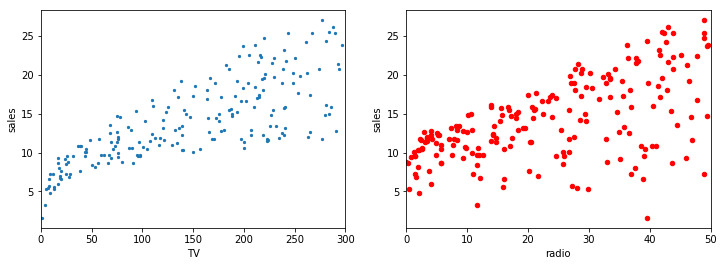

In [3]:
fix, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
df.plot(kind='scatter', x='TV', y='sales', ax=ax1, xlim=[0,300], s=5)
df.plot(kind='scatter', x='radio', y='sales', ax=ax2, s=20, color='red')
ax2.set_xlim(0,50)
plt.show()

## Linear Regression

We would now like to fit a linear model to predict sales based on predictors 'TV', 'Radio', and 'Newspaper'. This requires us to determine a measure fore the quality of a fit and how to use this measure to search for model parameters. 

### Least Mean Squares

Denote $y_i$, $x_i=(x_{i1},...,x_{ip})$ as the $i$-th vector of predictors and their (observed) response, with $i \in \{1,...,n \}$, and $b=(b_1,\dots,b_p)$ as vector of model parameters.

Given an observation $x_i$, the corresponding prediction is 

$$\hat{y_i} = b' x_i$$

Unless prediction is perfect, we measure the quality of the fit, or the error, as the squared difference between prediction and response, $(y_i - b' x_i)^2$.

With $Q \to b$ as the mean of squared differences, the objective is to select parameters $b$, such $Q(b)$ is minimized. 

$$Q(b) = \frac{1}{n}\sum_{i=1}^{n} \frac{1}{2} (y_i - b' x_i)^2$$

A possible solution is based on gradient descent. For this, we must first obtain the partial derivatives with respect to $b_j \in \{b_1,\dots,b_p \}$,

$$\begin{align}\frac{\partial Q(b)}{\partial b_j} &=  \frac{1}{n} \sum_{i=1}^{n} 2 \frac{1}{2}(y_i - b_j x_{ij})\frac{\partial }{\partial b_j} (y_i - b_j x_{ij})  \\&=  \frac{1}{n} \sum_{i=1}^{n} -(y_i - b_j x_{ij})x_{ij} \\&= \frac{1}{n} \sum_{i=1}^{n} (b_j x_{ij}-y_i)x_{ij}\end{align}$$

Instead of computing the point where all partial derivatives are jointly zero, we can compute the partial derivatives for a given $b$, which gives us the gradient of function $Q$ at this point,

$$\nabla Q(b) = -\left(\frac{\partial Q(b)}{\partial b_1},\dots,\frac{\partial Q(b)}{\partial b_p}\right)$$

The gradient provides us with the direction of steepest descent towards an optimal vector of parameters. 

### Sales Advertising Model

Our basic sales advertising model assumes a linear relationship between sales and investments in TV and radio ads:
    
$$\text{sales} = b_0 + b_1 \times \text{TV} +  b_2 \times \text{radio}$$

This leads us to the following linear model:

$$y_i = b_0 + b_1 \times x_{i1} +  b_2 x_{i2} = y,\ i=1,...,n$$

#### Data preparation
The column 'sales' from our DataFrame define the response vector $y$ and the columns 'TV', 'radio', and 'newspaper' define the predictor matrix $X$. For our algorithm, we additionally need a column of ones as the column of the matrix $X$ that is associated with $b_0$.

In [4]:
y = df.sales.values
X = df.drop(["sales"], axis=1).values
n = X.shape[0]
X = np.c_[np.ones(n),X]
p = X.shape[1]

### Batch Gradient Decent

Since the elements of the gradient are a function of $b$, we must select an initial point $b_0$ to obtain a gradient with constant elements. This gradient points in the direction of steepest descent at the given point $b_0$. We can therefore use this gradient to select a new point $b_1$ that is closer to the optimum than $b_0$. If we do this iteratively, we will obtain a sequence of $b$'s which will get closer and closer to the optimum.

A problem with gradient descent is that, as we approach the optimum the gradient may point towards the optimal $b$, but its length is larger than the step that needs to be take to get to $b^*$. We therefore work our way towards the optimum in smaller steps. The size of these steps, $\alpha$, also referred to as stepsize, is an important parameter in the gradient descent method, and subject to a lot of research.

1. Choose initial guess $\hat{b}_0$, stepsize $\alpha$ 
2. <b>for</b> k = 0, 1, 2, ... <b>do</b>
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\nabla Q_k(b_k) = -\frac{1}{n} \sum_{i=1}^{n}(\hat{b}_k' x_i - y_i)x_i$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat{b}_{k+1} = \hat{b}_k + \alpha \nabla Q_k(b_k)$ 

For our sales advertising model, we select $b_0=(0,0,0)$ and $\alpha=0.00001$ and compute a sequence of 100 $b$'s, after which the algorithm has hopefully converged towards a near-optimal solution.

In [5]:
b = np.zeros(p)
alpha = 0.00005
n = len(df)
for j in range(100):
    grad = 1.0/n*sum((y[i]-b.dot(X[i]))*-X[i] for i in range(len(X)))
    b = b - alpha*grad

Let us now compute the mean of the (residual) sum of squares (also known as the mean squared error or MSE), the $R^2$, as well as the vector of parameters.

In [6]:
rss =  sum((y[i]-b.dot(X[i]))**2 for i in range(n))
tss = sum((y[i]-y.mean())**2 for i in range(n))
r_squared = 1.-rss/tss
mse = rss/n
mse, r_squared, b

(5.0073153665972097,
 0.81513096288532916,
 array([ 0.00442134,  0.05619436,  0.15890942,  0.04975773]))

### Stochastic Gradient Descent

We compute the partial derivative by collecting the slopes associated with each observation $x_i$. An alternative to taking the sum is to keep updating the gradient while collecting these terms. If we additionally randomize the sequence in which we collect the terms, we arrive at an algorithm referred to as stochastic gradient decent.

Instead of computing the full gradient, we update the gradient after having obtained the fraction of the slope that corresponds to a randomly drawn observation $x_i$.

1. Choose initial guess $\hat{b}_0$, stepsize $\alpha$ 
2. <b>for</b> k = 0, 1, 2, ... <b>do</b>
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Draw randomly $i \sim U(1,n)$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\nabla Q_k = - (\hat{b}_k' x_i - y_i)x_i$
5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat{b}_{k+1} = \hat{b}_k + \alpha \nabla Q_k$

For our implementation, we now replace the inner loop and instead compute the gradient for only one observation. The index of that observation is draw uniformly from the range $[0,n]$.

Let us also select a vector of stepsizes $\alpha=(0.05,0.000005,0.0001,0.0001)$. Since parameters are associated with  features of different magintudes, better results can be obtained by selecting parameter-specific stepsizes.

In [7]:
b = np.zeros(p)
alpha = [0.05,0.000005,0.0001,0.0001]
n = len(df)
for j in range(100):
    i = random.randint(0,n-1)
    grad = (y[i]-b.dot(X[i]))*-X[i]
    b = b - alpha*grad  

Let us again look at MSE, $R^2$ and vector $b$.

In [8]:
rss =  sum((y[i]-b.dot(X[i]))**2 for i in range(n))
tss = sum((y[i]-y.mean())**2 for i in range(n))
r_squared = 1.-rss/tss
mse = rss/n
mse, r_squared, b

(3.3109831941657473,
 0.87775919226269172,
 array([ 2.56991997,  0.04651458,  0.19815713,  0.01774615]))

As we can see the stochastic version of the algorithm can obtain a higher quality solution with less work. In this case, this is due to the different choice of stepsizes, which highlights its importance for this class of algorithms.

### AdaGrad

Since gradient descent is highly dependent on the selected stepsize, it should ideally  be chosen for each dimension separately. There are numerous approaches to select stepsizes, one of which is AdaGrad.

AdaGrad is a simple extension of stochastic gradient descent to select a stepsize based on the magnitude of the gradient in each dimension.

In addition to computing the gradient, AdaGrad stores the sum of squared gradients. With $G= \nabla Q(b)$, we define the sum of previous squared gradients
as 

$$G_k=\left(\sum_{j=0}^k \nabla Q(b)_{1j}^2,...,\sum_{j=0}^k\nabla Q(b)_{1j}^2\right)$$

The stepsize now becomes the root of the sum of previous squared gradients:

$$\alpha_k=\left(\sqrt{G_{k1}},...,\sqrt{G_{kp}}\right)$$

The stochastic gradient descent algorithm using AdaGrad then becomes,

1. Choose initial guess $\hat{b}_0$, $G_0=0$ 
2. <b>for</b> k = 0, 1, 2, ... <b>do</b>
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Draw randomly $i \sim U(1,n)$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\nabla Q_k = - (\hat{b}_k' x_i - y_i)x_i$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $G_{k+1} = G_k+((\hat{b}_k' x_i - y_i)x_i)^2$
5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat{b}_{k+1} = \hat{b}_k + \frac{1}{\sqrt{G_{k+1}}} \nabla Q_k$

This algorithm is extremely easy to implement, it is theoretically sound and has been proven quite successful empirically.

### Optimal Solution

As mentioned above, the optimal vector $b^*$ can be obtained analytically by setting the partial derivatives jointly to zero, which entails solution of a system of equations, and as such requires matrix inversion. The method is typically referred to as ordinary least squares or OLS.

Let us skip the mathematical derivation of OLS and briefly present the OLS solution using scikit-learn's [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Running a simple regression on our model is quite simple. The only thing we must keep in mind is to inform the fitting method that the feature matrix already contains one column for the intercept.

In [9]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X,y)
reg.score(X,y)

0.89721063817895208

Let us again look at MSE, $R^2$ and vector $b$ which is an attribute of the regression instance.

In [10]:
b = reg.coef_
rss =  sum((y[i]-b.dot(X[i]))**2 for i in range(n))
tss = sum((y[i]-y.mean())**2 for i in range(n))
r_squared = 1.-rss/tss
mse = rss/n
mse, r_squared, b

(2.7841263145109361,
 0.89721063817895208,
 array([  2.93888937e+00,   4.57646455e-02,   1.88530017e-01,
         -1.03749304e-03]))

Comparing the $R^2$ with the one from above, we can see that with the right step size, our stochastic gradient descent algorithm is near optimal, with much less work.

### Variable Selection

Apart from the algorithms themselves, another important aspect in machine learning is variable selection. In linear models, often, not only the predictors themselves are used, but also combinations of predictors,

$$\text{sales} = b_0 + b_1 \times \text{TV} +  b_2 \times \text{radio} +  b_3 \times \text{TV} \times \text{radio} $$

Let us add this interaction to our model by appending a new column to our DataFrame that contains the product of 'TV' and 'Radio'.

In [11]:
X = np.c_[X,X[:,1]*X[:,2]]
reg.fit(X,y)
reg.score(X,y)

0.96782224347485135

In addition to looking at quality of fit measure, we can also visually inspect the model fit by plotting the residuals agains the individal parameters. This may help us to identify whether there is some non-linear behavious in the parameters that is not captured by our model.

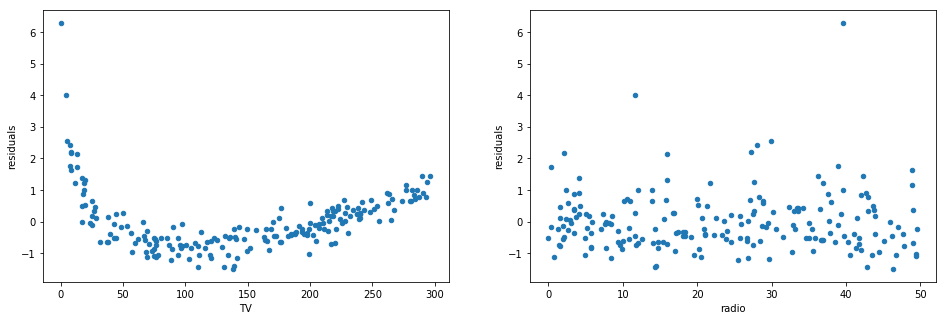

In [12]:
res = df.copy()
res['residuals'] = reg.predict(X)-y
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))
res.plot(kind='scatter', x='TV', y='residuals', ax=ax1)
res.plot(kind='scatter', x='radio', y='residuals', ax=ax2)
plt.show()

As we can see, there seems to be a non-linear relationship between 'TV' and the residuals. Especially, it appears that our prediction is too large for low and high values of 'TV' and too low for intermediate values. Let us therefore add polynomials of degree $d$ to our model.

$$\text{sales} = b_0 + b_1 \times \text{TV} +  b_2 \times \text{radio} +  b_3 \times \text{TV} \times \text{radio} + b_4\text{TV}^2 + ... + b_{d+2} \text{TV}^d $$

The question is now, how many degrees our polynomial should have and which terms to select. To automatically select the right number of polynomials of given degree $d$, we can use the Aikaike information criterion (AIC), 

$$AIC = 2p + n \ln \left( \frac{RSS}{n}\right)$$

The AIC measures the quality of our model relative to other candiate models by balancing model complexity against the goodness-of-fit (see: bias variance trade-off). In our linear model, model complexity scales with the number of parameters in our model, whereas goodness-of-fit is measured through the MSE.

### Cross Validation

Instead of using the AIC to select a model, we can use also cross validation. While cross validation is computationally more expensive, it is more generally applicable, and we will revisit it throughout this course for parameter / model selection.

For cross validation, we will use the object [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). All it does is provide an iterator over the k folds, each consisting of a pair of a set of indices, one for the test and one for the training set. These indices can then be used to select the elements that correspond to a set of observations from the complete data set.

For each fold, we will perform the regression on the training set and then compute the $R^2$ for the test set. We then sum up all the $R^2$ from each fold and compute its average, which will serve as our *out-of-sample* fit.

In [13]:
avg_score = 0.
for test,train in KFold(n_splits=5).split(X):
    X_test, X_train =  X[test], X[train] 
    y_test, y_train =  y[test], y[train]
    reg.fit(X_train,y_train)
    avg_score += reg.score(X_test,y_test)/5.
avg_score

0.95981390673489053

## Homework

Names: (put your names here)

### Exercise 1
Implement AdaGrad and use it to fit the linear advertising sales model. Wrap AdaGrad into a separate function that requires X and y as input arguments (optional: iterations, default = 10n) and returns the parameter vector b. This function should be used from now on two fit models. What do you observe when comparing it to stochastic gradient descent or the analytic solution using scikit-learn?

### Exercise 2
Run your algorithm to make the following prediction $$Sales = b_0 + b_1 TV$$ and plot the prediction against the original data using Matplotlib.

### Exercise 3
Write an automated variable selection method that searches for the best polynomial degrees of 'TV' and 'radio' up to degree 5. You can do this by iteratively adding a polynomial as an additional column to the feature matrix $X$. Use the AIC to keep track of trade-off between number of model parameters (features) and model fit (RSS) and exit when the minimum AIC is reached.

### Exercise 4
Now use cross validation to select the best order of the polynomial. Automatically stop when the minimum $MSE$ is reached. What do you observe when comparing it to the solution using the AIC?
